In [1]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen 
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import time
import requests
import scrapy
from scrapy.crawler import CrawlerProcess
import json
import numpy as np 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score,cross_val_predict



In [11]:
df1=pd.read_csv("Udmey Courses.csv")
df=pd.read_csv("Udmey Courses1.csv")

In [12]:
udmey=pd.concat([df1, df], join="outer")

In [14]:
udmey['Course Length']=udmey['Course Length'].str.strip(' total min').astype(np.float)
udmey['off_price']=udmey['off_price'].replace('F',None).astype(np.float)


<ipython-input-14-0ee27893ad17>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  udmey['Course Length']=udmey['Course Length'].str.strip(' total min').astype(np.float)
<ipython-input-14-0ee27893ad17>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  udmey['off_price']=udmey['off_price'].replace('F',None).astype(np.float)


In [18]:
for column in ['orig_price','off_price','Rating','Number of Ratings','Subscribers']:
    udmey[column]=udmey[column].fillna(udmey[column].mean())

In [19]:
udmey.isna().sum()

url                   0
Course Title          0
Course Headline       0
Instructor            0
off_price             0
orig_price            0
Rating                0
Number of Ratings     0
Course Length         0
Number of Lectures    0
Difficulity           0
Subscribers           0
dtype: int64

In [20]:
udmey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9968 entries, 0 to 7583
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 9968 non-null   object 
 1   Course Title        9968 non-null   object 
 2   Course Headline     9968 non-null   object 
 3   Instructor          9968 non-null   object 
 4   off_price           9968 non-null   float64
 5   orig_price          9968 non-null   float64
 6   Rating              9968 non-null   float64
 7   Number of Ratings   9968 non-null   float64
 8   Course Length       9968 non-null   float64
 9   Number of Lectures  9968 non-null   int64  
 10  Difficulity         9968 non-null   object 
 11  Subscribers         9968 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1012.4+ KB


In [21]:
udmey.describe()

,off_price,orig_price,Rating,Number of Ratings,Course Length,Number of Lectures,Subscribers
count,9968.000000,9968.000000,9968.000000,9968.000000,9968.000000,9968.000000,9968.000000
mean,17.239900,52.604088,4.194684,457.791016,7.637741,47.002508,6050.152036
std,14.940135,28.854682,0.513667,2459.577000,10.255304,58.381346,19410.600273
min,14.990000,19.990000,1.000000,1.000000,1.000000,4.000000,0.000000
25%,14.990000,19.990000,4.000000,15.000000,2.000000,16.000000,89.000000
50%,14.990000,52.604088,4.300000,55.000000,3.500000,29.000000,727.500000
75%,14.990000,89.990000,4.500000,283.000000,8.000000,55.000000,4459.250000
max,199.990000,129.990000,5.000000,98625.000000,125.500000,699.000000,471846.000000


As shown above, there are no missing values which is excellent!

It is vital to understand the features we are working with.

# Features in the DataFrame:

course_title: Title of course
    
url: Course URL
    
price: Price of course
    
num_subscribers: Number of subscribers for the course
    
num_lectures: Number of lectures in the course
    
Difficulity: Difficulty level of the course
    
content_duration: Duration of all course materials

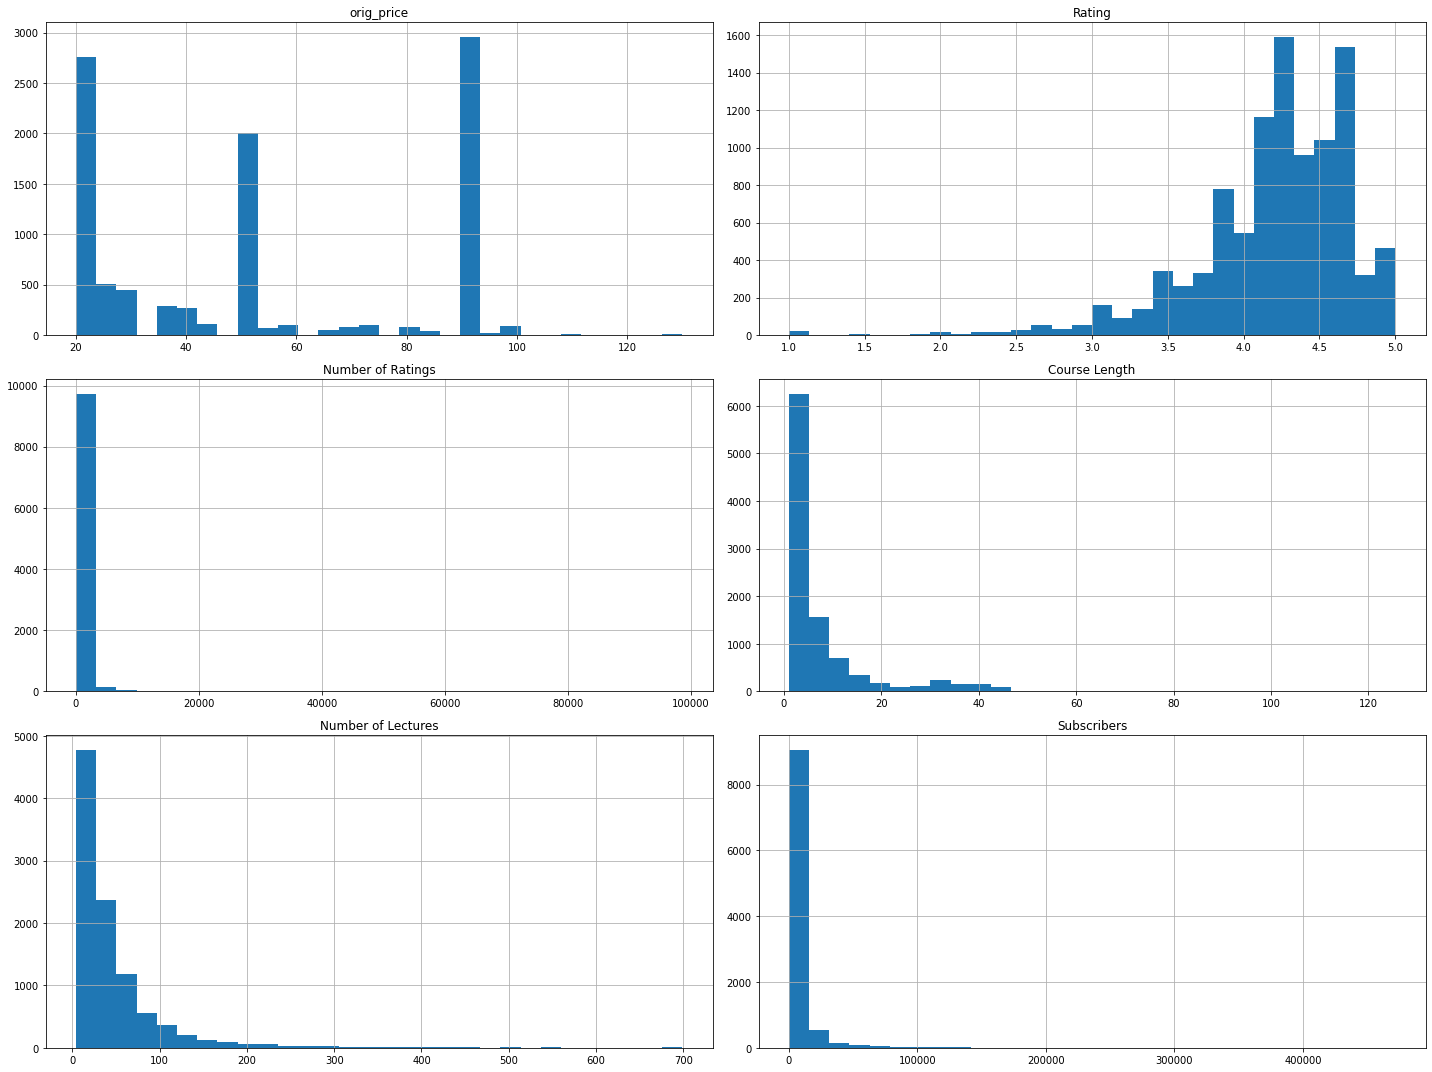

In [23]:
udmey.drop(["off_price"], axis=1).hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

Initial observations from the histograms:

Most course durations are between 0-60 min.

There are usually around 1-50 lectures per course.

Courses tend to have few reviews. There are probably a handful of courses with a large amount of reviews since the X axis goes up to 10000 while over 9000 instances are represented in the first bin.

The majority of courses are in the same range of subscribers. The instances farther up the scale were probably more successful or perhaps courses on a trending topic.

Assuming the prices are in USD, the range is between 0-120 dollars. The plot shows the most common price roughly 20 / 55 / 95 USD.

# Objective

Predicting the number of subscribers for a course.



Chosen Feature:

subscribers column

The column represents how many people have subscribed to each course.

# Motive:
Predicting the number of people subscribed to a course, course popularity.

Splitting the Data:

Before further analysis let's split the data into a training set and a testing set. This will ensure avoidance of bias that could occur from learning the data as a whole.

In [25]:

train_set, test_set = train_test_split(udmey, test_size=0.20, random_state=42)

In [26]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  7974
Number of instances in testing set:  1994


# Understanding and Visualizing the Data

In [27]:
df2 = train_set.copy()

In [28]:
df2.head(2)

,url,Course Title,Course Headline,Instructor,off_price,orig_price,Rating,Number of Ratings,Course Length,Number of Lectures,Difficulity,Subscribers
3940,https://www.udemy.com/course/mobile-computer-f...,Mobile Computer Forensics Fundamentals,Understanding the concepts and practices of mo...,John Boyle,14.99,59.99,4.1,12.0,2.0,21,Beginner,69.0
4524,https://www.udemy.com/course/webdev-3000/,WebDev 3000: Pure Python Web Sites,Creating & Testing Standards-Based Internet Ex...,Randall Nagy,14.99,19.99,3.3,8.0,6.5,45,Intermediate,4304.0


# Exploring Attribute Combinations

In [33]:
corr_matrix = df2.corr()
corr_matrix["Subscribers"].sort_values(ascending=False)

Subscribers           1.000000
Number of Ratings     0.660972
Number of Lectures    0.141142
orig_price            0.089785
Course Length         0.076074
Rating                0.066079
off_price            -0.034812
Name: Subscribers, dtype: float64

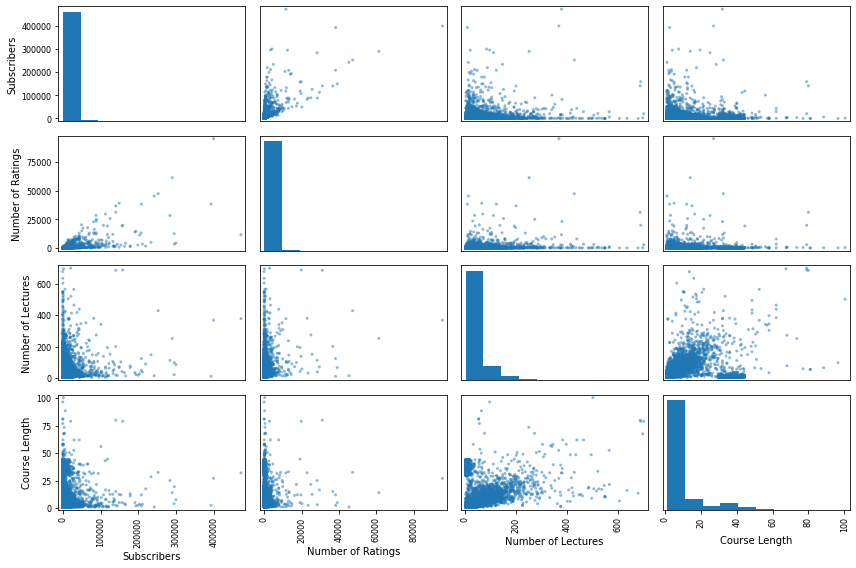

In [34]:
attributes = ["Subscribers", "Number of Ratings", "Number of Lectures", "Course Length"]

scatter_matrix(df2[attributes], figsize=(12,8))
plt.tight_layout()
plt.show()

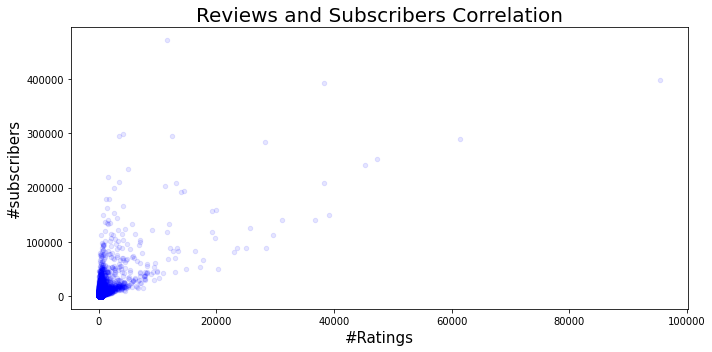

In [36]:
# scatter plot of the strongest correlation in the corr matrix
# the alpha is set to show the distribution more clearly
df2.plot(kind="scatter", x="Number of Ratings", y="Subscribers", alpha=0.1,
         color='b', figsize=(10,5))
plt.title("Reviews and Subscribers Correlation", size=20)
plt.xlabel("#Ratings", size=15)
plt.ylabel("#subscribers", size=15)
plt.tight_layout()
plt.show()

# Correlations with num_subscribers Attribute- Overview:

The strongest positive correlations (0.1 or more) are:

*Number of Ratings

*Number of Lectures

*Course Length 

The strongest negative correlations (-0.1 or less) are:

*off_price 

In [39]:
df2.drop_duplicates(inplace=True)

In [40]:
df2.shape

(7707, 12)

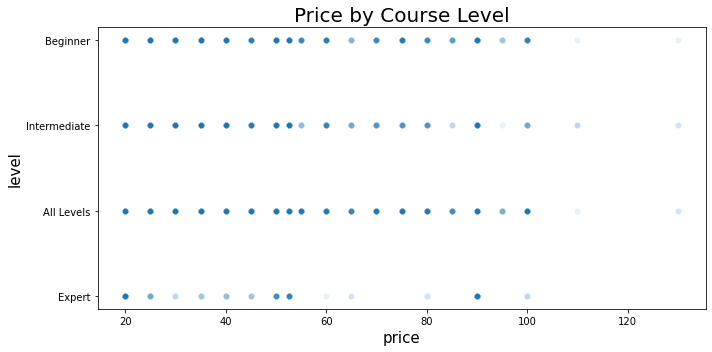

In [41]:
plt.figure(figsize=(10,5))
sns.scatterplot(y=df2["Difficulity"], x=df2["orig_price"], alpha=0.1)
plt.title("Price by Course Level", size=20)
plt.xlabel("price", size=15)
plt.ylabel("level", size=15)
plt.tight_layout()
plt.show()

# 

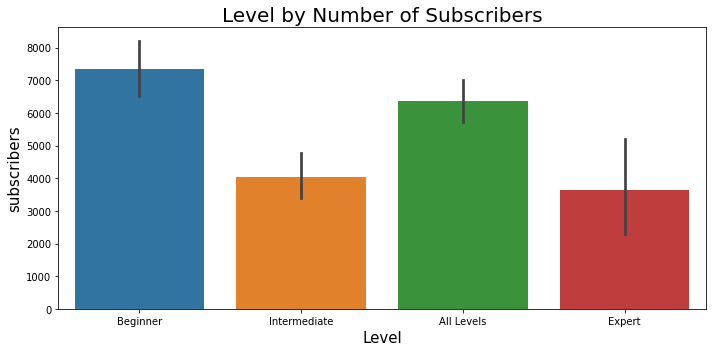

In [43]:
# plot subject by number of subscribers and level
# the black bars represent the error
plt.figure(figsize=(10,5))
sns.barplot(x=df2["Difficulity"], y=df2["Subscribers"])
plt.title("Level by Number of Subscribers", size=20)
plt.xlabel("Level", size=15)
plt.ylabel("subscribers", size=15)
plt.tight_layout()
plt.show()

# Observations:
*All Levels and Beginners are the most common level, representing over 50%.

*Price variations according to the level of the course also show that Expert is the least common level in the data. It is also the only level that does not provide free courses. The other levels are dispersed more frequently throughout the line.



In [44]:
df2.shape

(7707, 12)

Data Cleaning

In [45]:
df3 = train_set.copy()

In [46]:
df3.shape

(7974, 12)

In [47]:
X_train = df3.drop("Subscribers", axis=1)

# create a deep copy of the target values
y_train = df3["Subscribers"].copy()

# Removing the Following Columns:

The reason for removing these columns is for the model to generalize better. Furthermore, these columns have a unique value for each instance (i.e. URL,Instructor  ) which does not provide information the model can learn from to predict on new data.


Course_title

Course Headline

Instructor 

Rating 

Url

Off_price 

In [48]:
# list of numerical features
num_features = ["orig_price", "Number of Ratings", "Number of Lectures", "Course Length"]
Difficulites = ["All Levels", "Beginner", "Intermediate", "Expert"]

full_pipeline = ColumnTransformer([

# MinMaxScaler normalizes data (rescales between 0-1)
    ("num", MinMaxScaler(), num_features),

# OrdinalEncoder converts categories to integers according to order specified in list
    ("Difficulity", OrdinalEncoder(categories=[Difficulites]), ["Difficulity"]),

])



In [50]:
features = num_features+["Difficulity"]

In [52]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_tr_testing = full_pipeline.transform(X_train)